In [1]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
import matplotlib.pyplot as plt
ray.init()

2021-01-11 10:36:28,086	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:33372',
 'object_store_address': '/tmp/ray/session_2021-01-11_10-36-27_413902_1672834/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-11_10-36-27_413902_1672834/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-01-11_10-36-27_413902_1672834',
 'metrics_export_port': 64930,
 'node_id': 'ed4e0c10e60ffd8f28547015e36db3cc6c2836ec'}

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [2]:
# import data from DNN training
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [3]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 50000+ 1
L = 77

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00005

r_m = np.append(np.zeros(p), np.append(np.repeat(-6,p), 0))

tau_start = theta_m_1[q-1]

In [4]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

In [5]:
@ray.remote
def delta_beta(z, S, B_zeta, Lambda, beta):
    return (B_zeta.T.dot(z*1/S) - (B_zeta.T).dot(B_zeta).dot(beta) - beta/(Lambda**2))
@ray.remote
def delta_1_log_tau(p, log_tau, Lambda):
    tau = np.exp(log_tau)
    tau2 = tau**2
    Lambda2 = Lambda**2
    return(- (p-1) - (2*tau2)/(1+tau2) + 2*np.sum((Lambda2/tau2)/(1+Lambda2/(tau2))))

def generate_dS2_ddS2_S2_S(Lambda, BoB):
    
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    
    dS2, ddS2 = np.zeros((n,p)), np.zeros((n,p))
    #for lj in range(0, p):
    #    dS2[:,lj] = - BoB[:,lj]*Lambda2[lj]/((1+W)**2)
    #    ddS2[:,lj] = (-BoB[:,lj]*Lambda2[lj] + (BoB[:,lj]*(Lambda2[lj]**2)))/((1+W)**3)
    
    #dS2 = - (BoB.dot(np.diag(Lambda2)))/(((1+np.tile(W, [p,1]))**2).T)
    #dS2 = 0
    return(dS2, S2, S)

@ray.remote
def delta_1_lambda(Lambda, beta, B_zeta, dS2, S2, S, z, tau):
    p = len(Lambda)
    Lambda2 = Lambda**2
    tau2 = tau**2
    dlogFucj = np.zeros(p)
    #for lj in range(0,p):
    #    dlogFucj[lj] = 0.5*(beta[lj]**2)/Lambda2[lj] - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2) - 0.5*np.sum(dS2[:,lj]/S2) - 0.5*np.sum((z*z*(-dS2[:,lj]/(S2**2)))) + np.sum( beta.dot(B_zeta.T).dot(np.diag(-0.5*(dS2[:,lj]/(S2**(1.5))))).dot(z))  
    for lj in range(0, len(Lambda)):             
        dlogFucj[lj] = (0.5*(beta[lj]**2)/Lambda2[lj]
                         - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2)
                         + 0.5
                         + 0.5*np.sum((B_zeta[:,lj]**2)*Lambda2[lj]*S2)
                         - 0.5*np.sum((z**2)*(B_zeta[:,lj]**2)*Lambda2[lj])
                        + 0.5*(beta.T.dot(B_zeta.T)*S*(B_zeta[:,lj]**2)*(Lambda2[lj])).dot(z))
    return(dlogFucj)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, BoB):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    Lambda_t = np.exp(0.5*vartheta_new[p:2*p])
    log_tau_t = vartheta_new[2*p]

    dS2,  S2, S = generate_dS2_ddS2_S2_S(Lambda_t, BoB)

    ret_id1 = delta_beta.remote(z, S, B, Lambda_t, beta_t)
    ret_id2 = delta_1_lambda.remote(Lambda_t, beta_t, B, dS2, S2, S, z, np.exp(log_tau_t))
    ret_id3 = delta_1_log_tau.remote(p, log_tau_t, Lambda_t)
    grad_beta, grad_lambda, grad_tau = ray.get([ret_id1, ret_id2, ret_id3])

    return(np.append(grad_beta, np.append(grad_lambda, grad_tau)))

def log_density(S, B, beta, Lambda, log_tau, z, p):
    Lambda2 = Lambda**2
    tau2 = np.exp(log_tau)**2
    S2 = S**2

    square_term = (z - (np.array([B[:,i]*(S[i]) for i in range(0, B.shape[1])]).T.dot(beta)))
    term1 = - 0.5*np.sum(np.log(S2))  
    term2 = + 0.5*np.sum(np.log(Lambda2))  
    term3 = - 0.5*((square_term/S2).dot(square_term)) 
    term4 = -0.5*np.sum((beta**2)/(Lambda2)) 
    term5 = -(p-1)*log_tau 
    term6 = - np.sum(np.log(1+Lambda2/tau2))  
    term7 = - np.log(1 + tau2) #
    return(term1 + term2 + term3 + term4 + term5 + + term6 + term7 ) #+ term8 + term9

In [6]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt, i, L):
    
    # update theta
    theta_tilde = (theta + epsilon*r).reshape(2*p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, BoB)
    
    if i != L:
        # update momentum again
        r_tilde = r + (epsilon)*Delta_theta_tilde 
    
    
    return(theta_tilde, r_tilde)

In [42]:
theta_m_1 = np.load('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/all_thetas_try.npy', allow_pickle=True).tolist()
r_m = np.load('../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/r_m_try.npy', allow_pickle=True).tolist()

In [43]:
theta_m_1[8245] = np.array(theta_m_1[8245]).reshape(q,)
for i in range(0,20000):
    theta_m_1.append(None)
    r_m.append(None)

In [44]:
r_m[8245] = np.array(r_m[8245]).reshape(q,)

In [ ]:
seed = 6835963
r0 = np.repeat(None, 20000)
theta_tilde = np.repeat(None, 20000)
r_tilde = np.repeat(None, 20000)
log_dens = np.repeat(None, 20000)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
#theta_m_1 = np.repeat(None, M)
#r_m = np.repeat(None, M)
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.zeros(21)
r_tilde[0] = np.zeros(21)
##theta_m_1[1] =  np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
all_thetas = []
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
#r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
#r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
for m in tqdm(range(8352, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = np.array(theta_m_1[m]).reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt, i, L)
        
    # compute gradient with theta
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    dS2, S2, S =  generate_dS2_ddS2_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1): 
        print(np.mean(acc[-100:]))
    

  0%|          | 49/41649 [27:45<398:08:26, 34.45s/it]

0.6938775510204082


  0%|          | 149/41649 [1:22:48<366:59:02, 31.83s/it]

0.68


  1%|          | 234/41649 [2:08:23<379:00:48, 32.95s/it]

In [67]:
np.save('../../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/all_thetas_try.npy', np.array(all_thetas22))
np.save('../../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/r_m_try.npy', np.array(r_m))


<ipython-input-67-5cb6184cae44>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save('../../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/r_m_try.npy', np.array(r_m))


In [65]:
len(all_thetas22)

8354

In [59]:
all_thetas22 = np.load('../../../../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/all_thetas_try.npy', allow_pickle=True).tolist()


In [60]:
all_thetas22 = all_thetas22[:8246]

In [61]:
for i in range(0,len(all_thetas)):
    all_thetas22.append(list(all_thetas[i]))

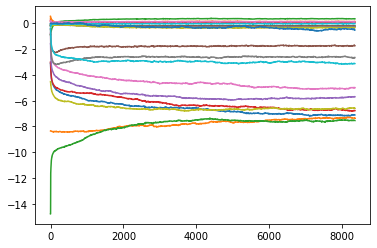

In [62]:
#plt.plot(all_thetas22)
plt.plot(all_thetas22)

In [ ]:
plt.plot(range(0,len(all_thetas22)), all_thetas22)
plt.plot(range(len(all_thetas22),len(all_thetas22) + len(all_thetas)), all_thetas)


In [ ]:
import os
os.getcwd()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)
#plt.ylim(-3,-1)

In [ ]:
df = np.array(all_thetas)
#np.std(df[4000:], axis = 0)

In [ ]:
plt.plot(df[0:100,0:10])
#plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
np.mean(acc)

In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.plot(df[:,0:10])

In [ ]:
theta_hmc = np.mean(all_thetas[50:], axis = 0)
theta_hmc_sd = np.std(all_thetas[50:], axis = 0)
#np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', np.array(all_taus[J[1]:]))

In [ ]:
theta_hmc

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')

In [ ]:
vartheta_bts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy')
vartheta_dts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy')

In [ ]:
B_ts = np.mean(vartheta_bts[10000:, :,:], axis = 0)
d_ts = np.mean(vartheta_dts[10000:, :,:], axis = 0)
va_sd = np.sqrt(np.diag(B_ts.dot(B_ts.T) + d_ts**2))

In [ ]:
theta_va = np.mean(vartheta_va[10000:, :,:], axis = 0)

In [ ]:
plt.scatter(theta_va[0:10], theta_hmc[0:10])
#plt.scatter(theta_va[10:20], theta_hmc[10:20])
#plt.scatter(theta_va[20], theta_hmc[20])
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
theta_va[0:10]

In [ ]:
plt.scatter(va_sd[0:10], theta_hmc_sd[0:10])
plt.scatter(va_sd[10:20], theta_hmc_sd[10:20])
plt.scatter(va_sd[20], theta_hmc_sd[20])
ident = [0, 1.0]
plt.plot(ident,ident)